In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from loader import CustomDataset
from unet import *
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from datetime import datetime
#from sacred import Experiment
from tqdm import tqdm
import os
from utils import *
from octave_unet import OctaveUnet

In [2]:
ROOT = "home/kakran/cityscapes-semantic-segmentation/"
bs = 1
lr = 0.001
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Running on ", device)

Running on  cuda:0


In [3]:
train_data = CustomDataset(mode = 'train')
validation_data = CustomDataset(mode = 'val')
test_data = CustomDataset(mode = 'test')
num_classes = train_data.classes   # classes = 4, (background, sky, car, road)

In [4]:
# creating dataloaders for train, val, test
train_loader = DataLoader(train_data, batch_size= bs, num_workers=10, shuffle= True, pin_memory=True)
val_loader = DataLoader(validation_data, batch_size= bs, num_workers=10, shuffle= True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size= bs, num_workers=4, pin_memory=True)

dataset_sizes = {'train': len(train_data), 'val':len(validation_data), 'test':len(test_data)}
loaders = {'train': train_loader, 'val':val_loader, 'test':test_loader}



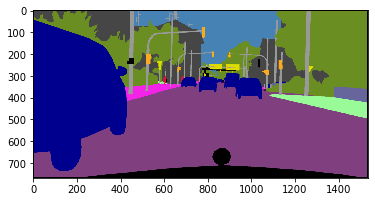

In [5]:
%matplotlib inline
im, mask_rgb, mask = next(iter(loaders['train']))
# the input image
imshow(np.transpose(im[0].numpy(), (1,2,0)), interpolation='nearest')

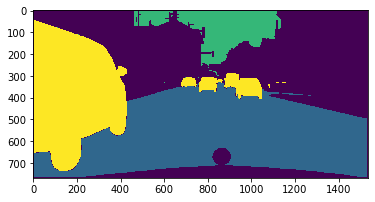

In [6]:
# mask for the image with 4 classes 
imshow(mask[0].numpy())

In [7]:
# initialize Unet network
network = OctaveUnet(num_classes).to(device)

In [8]:
optimizer = torch.optim.Adam(network.parameters(), lr=lr)

def define_loss(loss):
    """Define loss from 3 available losses.
    Return loss and dir_type to save output images and checkpoints"""
    
    if loss is "cross_entropy":
        # directly cross entropy loss could be used without the need of taking argmax over each pixel. It applies softmax over each pixel
        # and calculates loss for it over all classes. 
        criterion = nn.CrossEntropyLoss()
        dir_type = "cross_entropy"
    elif loss is "IoU":
        criterion = IoULoss()
        dir_type = "IoU"
    elif loss is 'dice':
        # dice loss
        criterion = SoftDiceLoss()
        dir_type = "dice"
    else:
        print('Select appropriate loss!')
        return None, None
    
    return criterion, dir_type

In [9]:

def classes_to_rgb( mask):
        '''Converts a class ids encoded mask to rgb encoded mask'''
        
        class_to_ids = {v:train_data.mappingrgb[k] for k,v in (train_data.mapping).items()} 
        target_im = torch.zeros((3, mask.shape[0], mask.shape[1]), dtype = torch.uint8)
        for k in class_to_ids:
            target_im[0][mask == k] = class_to_ids[k][0]
            target_im[1][mask == k] = class_to_ids[k][1]
            target_im[2][mask == k] = class_to_ids[k][2]
            
        return target_im

In [10]:
def train(epochs, network, criterion, optimizer, loaders, dataset_sizes, dir_type):
    training_losses = []
    val_losses = []
    for epoch in range(epochs):
        
        network = network.train()
        running_loss = 0.0
        for idx, (im, mask_rgb, mask ) in tqdm(enumerate(loaders['train']), ascii = True, desc = "Training"):

            optimizer.zero_grad()

            im = im.to(device)
            mask = mask.to(device)
            mask_rgb = mask_rgb.to(device)

            out = network(im)
            if dir_type in ('dice', 'IoU'):
                out = torch.softmax(out, dim = 1)
            loss = criterion(out, mask)
            loss.backward()

            optimizer.step()
            
            running_loss += loss.item() * im.shape[0]
            
            
        # calculate total loss for each epoch
        print('Epoch {}, loss on training set :{}'.format(epoch, running_loss/dataset_sizes['train']))
        training_losses.append(running_loss/dataset_sizes['train'])
        
        # on each epoch check the results on validation set
        if epoch%1 == 0:
            val_loss = 0
            snapshot(network, optimizer, criterion,dir_type, suffix = epoch)
            with torch.no_grad():
                
                # choose a random image to save from validation set
                random = np.random.randint(0,500)
                for idx, (im, mask_rgb, mask) in tqdm(enumerate(loaders['val']), ascii = True, desc = "Validating"):

                    im = im.to(device)
                    mask = mask.to(device)

                    out = network(im)
                    if dir_type in ('dice', 'IoU'):
                        out = torch.softmax(out, dim = 1)
                    loss = criterion(out, mask)
                    
                    if idx == random and epoch%4 == 0:
                        out = torch.argmax(out.squeeze(), dim = 0)
                        out = classes_to_rgb(out)
                        
                        # save original im, actual mask and generated mask 
                        save_image(im, filename = 'original_im_epoch_{}.png'.format(epoch), dir_type = dir_type)
                        save_mask(out, filename = 'output_mask_epoch_{}.png'.format(epoch),dir_type = dir_type)
                        save_image(mask_rgb, filename = 'actual_mask_epoch_{}.png'.format(epoch),dir_type = dir_type)
                    
                    val_loss += loss.item() * im.shape[0]
                
            val_losses.append(val_loss/dataset_sizes['val'])
            print("Epoch {}, loss on validation set :{}".format(epoch, val_loss/dataset_sizes['val']))
            
    # return all training and val losses
    return training_losses, val_losses

In [11]:
start = datetime.now()
epochs = 10
criterion , dir_type = define_loss("cross_entropy")
train_loss, val_loss = train(epochs, network, criterion, optimizer, loaders, dataset_sizes, dir_type)
end = datetime.now()
print("\n Total time taken", end - start)

Training: 2975it [26:09,  1.90it/s]


Epoch 0, loss on training set :0.052465553013999175


Validating: 500it [01:34,  5.46it/s]

Epoch 0, loss on validation set :0.016943716365844012



Training: 2975it [26:08,  1.91it/s]


Epoch 1, loss on training set :0.020839805272994796


Validating: 500it [01:33,  5.47it/s]

Epoch 1, loss on validation set :0.05439526088628918



Training: 2975it [26:07,  1.91it/s]


Epoch 2, loss on training set :0.015198658418708613


Validating: 500it [01:33,  5.49it/s]

Epoch 2, loss on validation set :0.03310753069911152



Training: 2975it [26:07,  1.90it/s]


Epoch 3, loss on training set :0.012487105991722655


Validating: 500it [01:33,  5.48it/s]

Epoch 3, loss on validation set :0.010178432767279446



Training: 2975it [26:07,  1.91it/s]


Epoch 4, loss on training set :0.011748665522298769


Validating: 500it [01:34,  5.49it/s]

Epoch 4, loss on validation set :0.010861535956617445



Training: 2975it [26:07,  1.90it/s]


Epoch 5, loss on training set :0.008485936944435562


Validating: 500it [01:33,  5.49it/s]

Epoch 5, loss on validation set :0.005992925588507205



Training: 2975it [26:07,  1.90it/s]


Epoch 6, loss on training set :0.010378483975572245


Validating: 500it [01:33,  5.47it/s]

Epoch 6, loss on validation set :0.006147114492719993



Training: 2975it [26:07,  1.91it/s]


Epoch 7, loss on training set :0.005222548146207794


Validating: 500it [01:33,  5.48it/s]

Epoch 7, loss on validation set :0.010363397627137602



Training: 2975it [26:06,  1.91it/s]


Epoch 8, loss on training set :0.00800683609155171


Validating: 500it [01:34,  5.47it/s]

Epoch 8, loss on validation set :0.00551509025041014



Training: 2975it [26:06,  1.91it/s]


Epoch 9, loss on training set :0.006967111758011229


Validating: 500it [01:33,  5.47it/s]

Epoch 9, loss on validation set :0.005269239630084485

 Total time taken 4:37:09.075597


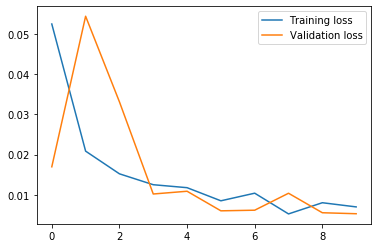

In [12]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(("Training loss", "Validation loss"))

In [25]:
# model and optimizer could be loaded from saved checkpoints in case of evaluation on test data
model, optim = load_model(epochs)
model = model.eval()